# Проверка гипотезы  и анализ результатов А/В - теста

**Описание проекта:**
Совместно с отделом маркетинга крупного интернет-магазина был подготовлен список гипотез для увеличения выручки. Необходимо приоритизировать гипотезы, запустить А/В-тест и проанализировать результаты. 

Имеются следующие данные:  
Файл  с гипотезами и их параметрами ```/datasets/hypothesis.csv``` 
 - Hypothesis — краткое описание гипотезы;
 - Reach — охват пользователей по 10-балльной шкале;
 - Impact — влияние на пользователей по 10-балльной шкале;
 - Confidence — уверенность в гипотезе по 10-балльной шкале;
 - Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.  
 
Файл с данными о заказах ```/datasets/orders.csv```
 - transactionId — идентификатор заказа;
 - visitorId — идентификатор пользователя, совершившего заказ;
 - date — дата, когда был совершён заказ;
 - revenue — выручка заказа;
 - group — группа A/B-теста, в которую попал заказ.  
 
Файл с данными о посещениях ```/datasets/visitors.csv```
 - date — дата;
 - group — группа A/B-теста;
 - visitors — количество пользователей в указанную дату в указанной группе A/B-теста

**Цель исследования:**
Увеличить выручку путем определения наиболее приоритетной гипотезы и анализа результатов А/В-теста.

**Ход исследования:**  
1) Изучить данные и подготовить их для анализа;  
2) Приоритизировать гипотезы;  
3) Провести анализ А/В-теста:  
   - Изучить стабильность кумулятивных метрик;
   - Провести анализ аномалий;
   - Посчитать статистическую значимость по "сырым" данным;
   - Посчитать статистическую значимость по "очищенным" данным;  

4) Оформить результаты в общем выводе

## Изучение данных и подготовка к анализу

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visits = pd.read_csv('/datasets/visitors.csv')
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
    visits = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [3]:
display(hypothesis.head())
display(orders.head())
visits.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [4]:
hypothesis.columns = hypothesis.columns.str.lower()
orders.rename(columns = {'transactionId':'transaction_id', 'visitorId':'visitor_id'}, inplace=True)

In [5]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [8]:
orders['date'] = orders['date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visits['date'] = visits['date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [9]:
hypothesis.duplicated().sum()

0

In [10]:
orders.duplicated().sum()

0

In [11]:
visits.duplicated().sum()

0

In [12]:
# Посмотрим сколько всего посетителей в группах
visits[visits['group'] == 'A']['visitors'].sum()

18736

In [13]:
visits[visits['group'] == 'B']['visitors'].sum()

18916

In [14]:
# Проверим не попадают ли покупатели в обе группы
len(
    set(
        orders[orders['group'] == "A"]['visitor_id']
    ) 
    & set(
        orders[orders['group'] == "B"]['visitor_id']
    )
)

58

Пропуски и дубликаты в таблицах отстутствуют. Данные с датами приведены к соответствующему формату.  
Количество пользователей в обеих группах приблизительно одинаково.  
Обнаружено, что 58 покупателей попадают в обе группы, это некорректно, но так как невозможно учесть этих покупателей в данных о посещениях, придется их оставить.

## Приоритизация гипотез

In [15]:
hypothesis['ICE'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)
pd.set_option('display.max_colwidth', None)
hypothesis.sort_values('ICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


In [16]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
pd.set_option('display.max_colwidth', None)
hypothesis.sort_values('RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


При расчете ICE первой по приоритету оказалась гипотеза под номером 8, а при использовании RICE самой приоритетной гипотезой стала под номером 7. Решающим оказалось значение Reach, т.е. число пользователей, которых затронет изменение. Для гипотезы под номером 7 характерно наиболее высокое значение Reach, что вывело ее в лидеры, а для гипотезы под номером 8 - самое маленькое значение Reach, из-за чего она оказалась лишь пятой по приоритету.  

Таким образом, первой будем тестировать гипотезу "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". Далее анализируем результаты этого А/В-теста.

## Анализ A/B-теста

### График кумулятивной выручки по группам

In [17]:
orders_daily = (
    orders.groupby(['group','date'], as_index=False)
    .agg({'revenue':'sum', 'transaction_id':'nunique', 'visitor_id':'nunique'})
)
orders_daily.rename(columns={'transaction_id':'orders', 'visitor_id':'buyers'}, inplace=True)
orders_daily.head()

,group,date,revenue,orders,buyers
0,A,2019-08-01,148579,24,20
1,A,2019-08-02,93822,20,19
2,A,2019-08-03,112473,24,24
3,A,2019-08-04,70825,16,15
4,A,2019-08-05,124218,25,25


In [18]:
ordersA_daily = orders_daily[orders_daily['group'] == 'A']
ordersB_daily = orders_daily[orders_daily['group'] == 'B']

In [19]:
ordersA_cumul = ordersA_daily.apply(
    lambda x: ordersA_daily[ordersA_daily['date'] <= x['date']]
    .agg({'date':'max', 'revenue':'sum', 'orders':'sum', 'buyers':'sum'}), 
    axis=1
)
ordersA_cumul.head()

,date,revenue,orders,buyers
0,2019-08-01,148579,24,20
1,2019-08-02,242401,44,39
2,2019-08-03,354874,68,63
3,2019-08-04,425699,84,78
4,2019-08-05,549917,109,103


In [20]:
ordersB_cumul = ordersB_daily.apply(
    lambda x: ordersB_daily[ordersB_daily['date'] <= x['date']]
    .agg({'date':'max', 'revenue':'sum', 'orders':'sum', 'buyers':'sum'}), 
    axis=1
)
ordersB_cumul.head()

,date,revenue,orders,buyers
31,2019-08-01,101217,21,20
32,2019-08-02,266748,45,43
33,2019-08-03,380996,61,59
34,2019-08-04,489567,78,75
35,2019-08-05,581995,101,98


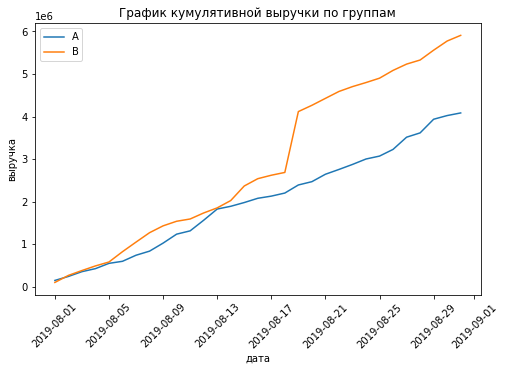

In [21]:
plt.figure(figsize=(8,5))
plt.plot(ordersA_cumul['date'], ordersA_cumul['revenue'], label='A')
plt.plot(ordersB_cumul['date'], ordersB_cumul['revenue'], label='B')
plt.legend()
plt.xlabel('дата')
plt.ylabel('выручка')
plt.title('График кумулятивной выручки по группам')
plt.xticks(rotation=45);

В группе А график выручки равномерно растет, в группе В в середине месяца наблюдается резкий скачок. Возможно появились очень дорогие заказы или увеличилось их количество. В целом на данном графике выручка в группе В несколько выше, чем в группе А. 

### Графики кумулятивного среднего чека по группам и относительного изменения кумулятивного среднего чека 

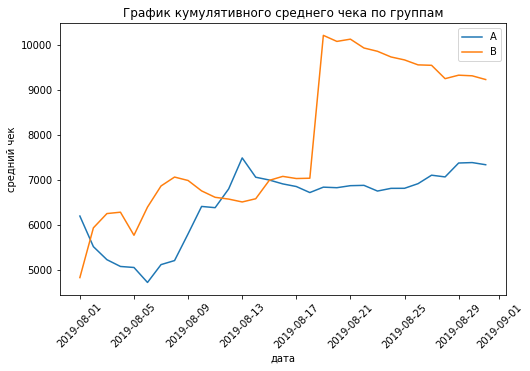

In [22]:
plt.figure(figsize=(8,5))
plt.plot(ordersA_cumul['date'], ordersA_cumul['revenue'] / ordersA_cumul['orders'], label='A')
plt.plot(ordersB_cumul['date'], ordersB_cumul['revenue'] / ordersB_cumul['orders'], label='B')
plt.legend()
plt.xlabel('дата')
plt.ylabel('средний чек')
plt.title('График кумулятивного среднего чека по группам')
plt.xticks(rotation=45);

На графике среднего чека также наблюдается скачок в середине месяца в группе В. Скорее всего в группу В попали дорогие заказы. К концу месяца средний чек в группе А более стабильный по сравнению с начальным периодом.

In [23]:
orders_cumul = ordersA_cumul.merge(ordersB_cumul, on='date', suffixes=['A', 'B'])

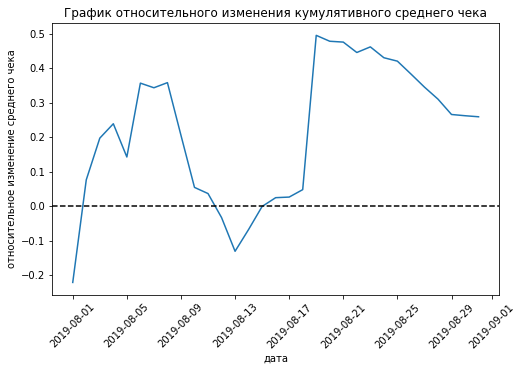

In [24]:
plt.figure(figsize=(8,5))
plt.plot(
    orders_cumul['date'], 
    (orders_cumul['revenueB'] / orders_cumul['ordersB']) / (orders_cumul['revenueA'] / orders_cumul['ordersA']) - 1
)
plt.xlabel('дата')
plt.ylabel('относительное изменение среднего чека')
plt.title('График относительного изменения кумулятивного среднего чека')
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45);

График имеет резкие скачки. Необходимо провести анализ выбросов.

### График кумулятивного среднего количества заказов на посетителя по группам и относительного изменения кумулятивного среднего количества заказов

In [25]:
data_daily = orders_daily.merge(visits, on=['date','group'])
data_daily.head()

,group,date,revenue,orders,buyers,visitors
0,A,2019-08-01,148579,24,20,719
1,A,2019-08-02,93822,20,19,619
2,A,2019-08-03,112473,24,24,507
3,A,2019-08-04,70825,16,15,717
4,A,2019-08-05,124218,25,25,756


In [26]:
data_cumul = visits[['date', 'group']].apply(
    lambda x: data_daily[np.logical_and(
        data_daily['date'] <= x['date'],
        data_daily['group'] == x['group']
        )].agg({'date':'max', 'group':'max', 'orders':'sum', 'visitors':'sum'}), axis=1
    )
data_cumul

,date,group,orders,visitors
0,2019-08-01,A,24,719
1,2019-08-02,A,44,1338
2,2019-08-03,A,68,1845
3,2019-08-04,A,84,2562
4,2019-08-05,A,109,3318
...,...,...,...,...
57,2019-08-27,B,548,16523
58,2019-08-28,B,576,17177
59,2019-08-29,B,596,17708
60,2019-08-30,B,620,18198


In [27]:
data_cumulA = data_cumul[data_cumul['group'] == 'A'][['date', 'orders', 'visitors']]
data_cumulB = data_cumul[data_cumul['group'] == 'B'][['date', 'orders', 'visitors']]

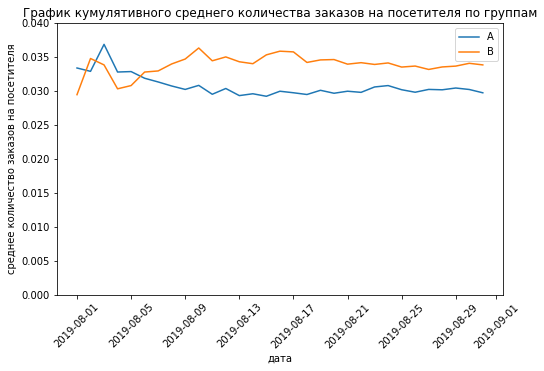

In [28]:
plt.figure(figsize=(8,5))
plt.plot(
    data_cumulA['date'], 
    data_cumulA['orders'] / data_cumulA['visitors'],
    label='A'
)
plt.plot(
    data_cumulB['date'], 
    data_cumulB['orders'] / data_cumulB['visitors'],
    label='B'
)
plt.legend()
plt.ylim(0, 0.04)
plt.xlabel('дата')
plt.ylabel('среднее количество заказов на посетителя')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xticks(rotation=45);

К концу периода среднее количество заказов установилось около определенных значений. Среднее количество заказов в группе В больше, чем в группе А.

In [29]:
data_cumul_merged = data_cumulA.merge(data_cumulB, on='date', suffixes=['A', 'B'])

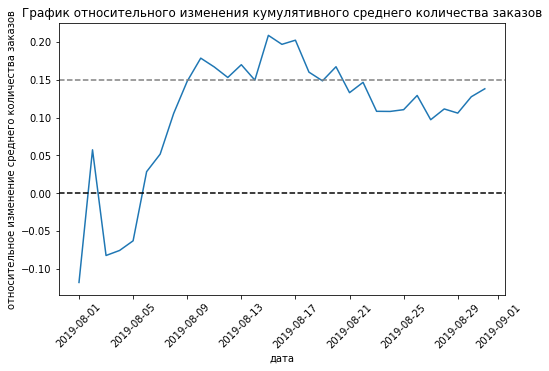

In [30]:
plt.figure(figsize=(8,5))
plt.plot(
    data_cumul_merged['date'], 
    (
        data_cumul_merged['ordersB'] / data_cumul_merged['visitorsB']) / 
        (data_cumul_merged['ordersA'] / data_cumul_merged['visitorsA']
        ) - 1
)
plt.xlabel('дата')
plt.ylabel('относительное изменение среднего количества заказов')
plt.title('График относительного изменения кумулятивного среднего количества заказов')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.xticks(rotation=45);

Судя по этому графику среднее количество заказов в группе В стабильно лучше чем в группе А. Однако необходимо провести расчет статистической значимости.

### Анализ выбросов

In [31]:
orders_cnt = orders.groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique', 'group':'max'})
orders_cnt.columns = ['user_id', 'orders', 'group']

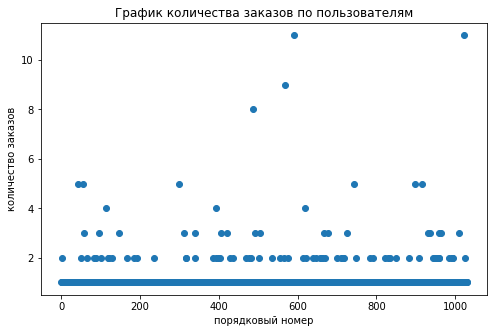

In [32]:
plt.figure(figsize=(8,5))
x_values = pd.Series(range(0, len(orders_cnt['orders'])))
plt.scatter(x_values, orders_cnt['orders'])
plt.title('График количества заказов по пользователям')
plt.ylabel('количество заказов')
plt.xlabel('порядковый номер');

In [33]:
np.percentile(orders_cnt['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей делали больше 2 заказов, не более 1% пользователей делали более 4 заказов. 
Можно отсеять пользователей, сделавших 2 и более заказов.

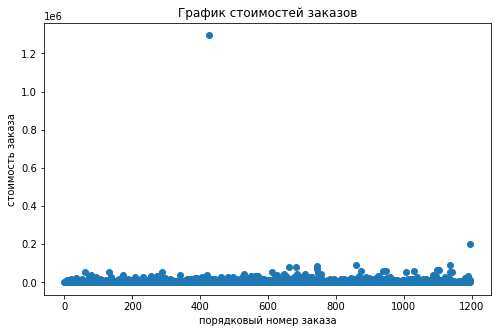

In [34]:
plt.figure(figsize=(8,5))
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('График стоимостей заказов')
plt.ylabel('стоимость заказа')
plt.xlabel('порядковый номер заказа');

Один заказ стоит аномально дорого по сравнению со всеми - его стоимость порядка миллиона.   
Приблизим масштаб чтобы увидеть как распределена стоимость до 100 тыс:

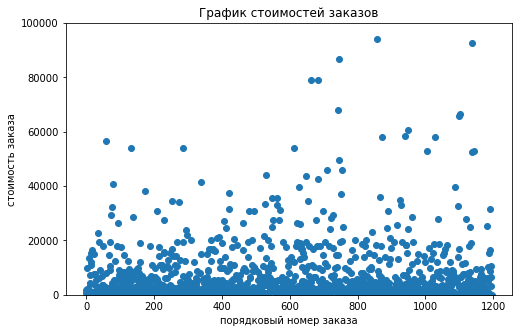

In [35]:
plt.figure(figsize=(8,5))
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylim(0, 100000)
plt.title('График стоимостей заказов')
plt.ylabel('стоимость заказа')
plt.xlabel('порядковый номер заказа');

In [36]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 5% заказов стоят дороже 28000, не более 1% заказов стоят дороже 58233. 
Примем за аномальные заказы стоимостью от 28000. Отсеем пользователей совершивших такие заказы. 

### Расчет статистической значимости по "сырым" данным

**Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.**

In [37]:
orders_by_usersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id':'nunique'})
)
orders_by_usersA.columns = ['user_id', 'orders']

orders_by_usersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id':'nunique'})
)
orders_by_usersB.columns = ['user_id', 'orders']

In [38]:
# добавим к данным с количеством заказов на покупателей нули для посетителей, которые ничего не купили
sampleA = pd.concat(
    [
        orders_by_usersA['orders'],
        pd.Series(
            0, 
            index=np.arange(
                visits[visits['group'] == 'A']['visitors'].sum() - len(orders_by_usersA['orders'])
            )
        )
    ],
    axis=0
)
sampleA.count()

18736

In [39]:
sampleB = pd.concat(
    [
        orders_by_usersB['orders'],
        pd.Series(
            0, 
            index=np.arange(
                visits[visits['group'] == 'B']['visitors'].sum() - len(orders_by_usersB['orders'])
            )
        )
    ],
    axis=0
)
sampleB.count()

18916

Для проверки гипотезы используем критерий Манна-Уитни, поскольку в данных есть значительные выбросы.

Сформулируем гипотезы:
- Нулевая гипотеза: Нет статистически значимых различий в среднем количестве заказов на посетителя между группами по "сырым" данным. 
- Альтернативная гипотеза: Есть статистически значимые различия в среднем количестве заказов на пользователя между группами по "сырым" данным.

Выберем уровень статистической значимости - 5%.

In [40]:
print('p-value:', '{0:.3f}'.format(st.mannwhitneyu(sampleA, sampleB)[1]))

p-value: 0.017


In [41]:
print('Относительное изменение среднего количества заказов:', 
      '{0:.2f}'.format(sampleB.mean() / sampleA.mean() -1)
)

Относительное изменение среднего количества заказов: 0.14


P-value ниже уровня статистической значимости, значит нулевую гипотезу отвергаем.   
Относительный прирост среднего количества заказов в группе В, по сравнению с группой А - 14%, это статистически значимое различие.

**Посчитаем статистическую значимость различий в средних чеках заказов между группами по «сырым» данным.**

Также используем критерий Манна-Уитни для проверки гипотезы.

- Нулевая гипотеза: Нет статистически значимых различий в средних чеках между группами по "сырым" данным.
- Альтернативная гипотеза: Есть статистически значимые различия в средних чеках между группами по "сырым" данным. 

Уровень статистической значимости - 5%.

In [42]:
print('p-value:', '{0:.3f}'.format(
    st.mannwhitneyu(
        orders[orders['group'] == 'A']['revenue'], 
        orders[orders['group'] == 'B']['revenue']
    )[1]
))

p-value: 0.729


In [43]:
print('Относительное отличие средних чеков между группами:', 
      '{0:.2}'.format(
          orders[orders['group'] == 'B']['revenue'].mean() 
          / orders[orders['group'] == 'A']['revenue'].mean() - 1
     )
)

Относительное отличие средних чеков между группами: 0.26


P-value выше уровня статистической значимости, нулевую гипотезу нельзя отвергнуть. Относительное отличие среднего чека в группе В по отношению к группе А - 26%, оно статистически не значимо.

### Расчет статистической значимости по "очищенным" данным

**Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.**   

Удалим данные о пользователях, сделавших 2 и более заказов и заказы на сумму от 28000.

- Нулевая гипотеза: Нет статистически значимых различий в среднем количестве заказов на посетителя между группами по "очищенным" данным. 
- Альтернативная гипотеза: Есть статистически значимые различия в среднем количестве заказов на пользователя между группами по "очищенным" данным.

Уровень статистической значимости - 5%.

In [44]:
# Создадим переменную с "аномальными" пользователями
users_many_orders = pd.concat(
    [
        orders_by_usersA[orders_by_usersA['orders'] >= np.percentile(orders_cnt['orders'], 95)]['user_id'],
        orders_by_usersB[orders_by_usersB['orders'] >= np.percentile(orders_cnt['orders'], 95)]['user_id'],
    ],
    axis=0,
)
users_expensive_orders = orders[orders['revenue'] >= np.percentile(orders['revenue'], 95)]['visitor_id']

abnormal_users = (
    pd.concat([users_many_orders, users_expensive_orders], axis=0)
    .drop_duplicates()
)

abnormal_users.count()

111

In [45]:
sampleA_purified = pd.concat(
    [
        orders_by_usersA[np.logical_not(orders_by_usersA['user_id'].isin(abnormal_users))]['orders'],
        pd.Series(
            0, index=np.arange(visits[visits['group'] == 'A']['visitors'].sum() - len(orders_by_usersA))
        )
    ], axis=0
)
sampleA_purified.count()

18669

In [46]:
sampleB_purified = pd.concat(
    [
        orders_by_usersB[np.logical_not(orders_by_usersB['user_id'].isin(abnormal_users))]['orders'],
        pd.Series(
            0, index=np.arange(visits[visits['group'] == 'B']['visitors'].sum() - len(orders_by_usersB))
        )
    ], axis=0
)
sampleB_purified.count()

18844

In [47]:
print('p-value:', '{0:.3f}'.format(st.mannwhitneyu(sampleA_purified, sampleB_purified)[1]))

p-value: 0.016


In [48]:
print('Относительное изменение среднего количества заказов:', 
      '{0:.2}'.format(sampleB_purified.mean() / sampleA_purified.mean() - 1)
     )

Относительное изменение среднего количества заказов: 0.17


p-value по-прежнему меньше уровня статистической значимости и нулевая гипотеза отвергается. Относительное изменение среднего количества заказов на пользователя по "очищенным" данным стало 17%. Это статистически значимое отличие.

**Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.**

- Нулевая гипотеза: Нет статистически значимых различий в средних чеках между группами по "очищенным" данным.
- Альтернативная гипотеза: Есть статистически значимые различия в средних чеках между группами по "очищенным" данным.  

Уровень статистической значимости - 5%.

In [49]:
print('p-value:', '{0:.3}'.format(
    st.mannwhitneyu(
        orders[
            np.logical_and(
                orders['group'] == 'A', 
                np.logical_not(
                    orders['visitor_id'].isin(abnormal_users)
                )
            )
       ]['revenue'],
        orders[
            np.logical_and(
                orders['group'] == 'B', 
                np.logical_not(
                    orders['visitor_id'].isin(abnormal_users)
                )
            )
       ]['revenue']
    )[1]
))

p-value: 0.835


In [50]:
print('Относительное отличие средних чеков между группами:', "{0:.2f}".format(
    (
    orders[
        np.logical_and(
            orders['group'] == 'B', 
            np.logical_not(
                orders['visitor_id'].isin(abnormal_users)
            )
        )
    ]['revenue'].mean() /
    orders[
        np.logical_and(
            orders['group'] == 'A', 
            np.logical_not(
                orders['visitor_id'].isin(abnormal_users)
            )
        )
    ]['revenue'].mean()
    ) - 1
))

Относительное отличие средних чеков между группами: -0.01


Так же как при расчете по "сырым" данным p-value выше уровня статистической значимости, нулевую гипотезу нельзя отвергнуть. Однако изменилось относительное отличие среднего чека с 26% до 1% с проигрышем группы В.

Посмотрим как изменились графики кумулятивных метрик при удалении выбросов:

In [51]:
data_daily_purified = (
    orders.query('visitor_id not in @abnormal_users')
    .groupby(['group','date'], as_index=False)
    .agg({'revenue':'sum', 'transaction_id':'nunique', 'visitor_id':'nunique'})
    .merge(visits, on=['date','group'])
)
data_daily_purified.rename(columns={'transaction_id':'orders', 'visitor_id':'buyers'}, inplace=True)

In [52]:
data_cumul_purified = visits[['date', 'group']].apply(
    lambda x: data_daily_purified[np.logical_and(
        data_daily_purified['date'] <= x['date'],
        data_daily_purified['group'] == x['group']
        )].agg({'date':'max', 'group':'max', 'revenue':'sum', 'orders':'sum', 'visitors':'sum'}), axis=1
    )
A_cumul_purified = data_cumul_purified[data_cumul_purified['group'] == 'A']
B_cumul_purified = data_cumul_purified[data_cumul_purified['group'] == 'B']

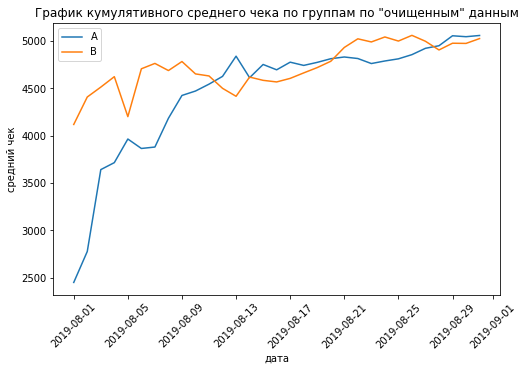

In [53]:
plt.figure(figsize=(8,5))
plt.plot(A_cumul_purified['date'], A_cumul_purified['revenue'] / A_cumul_purified['orders'], label='A')
plt.plot(B_cumul_purified['date'], B_cumul_purified['revenue'] / B_cumul_purified['orders'], label='B')
plt.legend()
plt.xlabel('дата')
plt.ylabel('средний чек')
plt.title('График кумулятивного среднего чека по группам по "очищенным" данным')
plt.xticks(rotation=45);

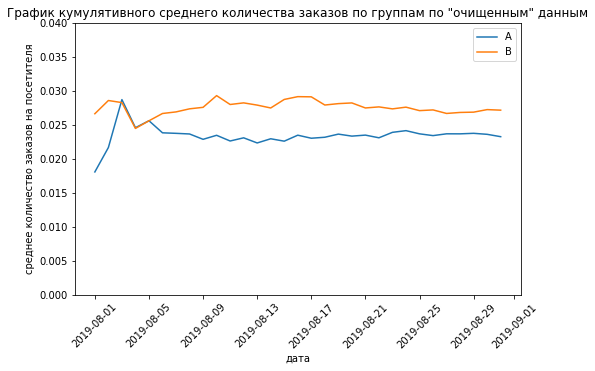

In [54]:
plt.figure(figsize=(8,5))
plt.plot(
    A_cumul_purified['date'], 
    A_cumul_purified['orders'] / A_cumul_purified['visitors'],
    label='A'
)
plt.plot(
    B_cumul_purified['date'], 
    B_cumul_purified['orders'] / B_cumul_purified['visitors'],
    label='B'
)
plt.legend()
plt.xlabel('дата')
plt.ylabel('среднее количество заказов на посетителя')
plt.title('График кумулятивного среднего количества заказов по группам по "очищенным" данным')
plt.ylim(0, 0.04)
plt.xticks(rotation=45);

## Общий вывод

В исследовании были изучены имеющиеся данные, преобразованы названия столбцов, столбцы с датами приведены к соответствующему формату. Пропуски и дубликаты в данных отсутствовали. Проверено равенство трафика в группах.

Были приоритизированы гипотезы способами ICE и RICE. С помощью RICE была определена наиболее приоритетная гипотеза, которая затрагивает большее число пользователей. Наиболее приоритетная гипотеза: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". Для ее проверки проанализованы результаты А/В-теста.

Построены графики кумулятивных метрик и их относительного изменения. По графикам выручки и среднего чека удалось определить наличие выбросов в данных.

Проведен анализ выбросов в стоимости и количестве заказов на пользователя: построены графики и посчитаны перцентили. За аномальных пользователей приняли тех, кто сделал 2 и более заказов и заказы стоимостью от 28000. Получили "очищенные" данные после удаления таких покупателей. 

Проведены расчеты статистической значимости по "сырым" и "очищенным" данным. В результате установлено, что среднее количество заказов на пользователя в группе В больше, чем в группе А. При этом относительное изменение по "очищенным" данным составило 17%. Средний чек не изменился в группе В по сравнению с группой А.  
Таким образом, тест можно остановить и зафиксировать победу группы В, так как увеличение прибыли реализуется за счет большего количества заказов.